# Predicting Car Fuel Consumption

In this example we are going to create a regression model with Keras Tensorflow which aims to predict the efficiency of a fleet of cars.

The dataset can be found at:

[Auto MPG Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/)

We are going to put in practice some techniques to tackle this regresion problem, like "bucketizing" numerical features.

Also though it is a rather simple problem, we will apply some best practices in terms of choices for initialization, callbacks, hyperparameter tunning, optimizer, batch size, learning rate, dropout etc...


In [2]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import seaborn as sns
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## Import Dataset

In [3]:
# The dataset can be read directly from the url, or if you do not have connection, from a local folder like ../data

#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

path = '../data/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Attribute Information:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete


## Dataset Preprocesssing

In [4]:
# Count NaN
print(df.isnull().sum())

# As there are only 6 null values we drop them in a new dataframe
df_clean = df.dropna().reset_index(drop=True)
df_clean.head()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


df_clean_copy = df_clean.copy()
df_clean_copy['Origin'] = df_clean_copy['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_clean_copy = pd.get_dummies(df_clean_copy, columns=['Origin'], prefix='', prefix_sep='')
df_clean_copy.tail()

## Feature Importance Calculation

In the following cells we calculate the influence of the input variables over the MPG (miles per gallon), which is the intended variable to be predicted.

The results are the same with both procedures.

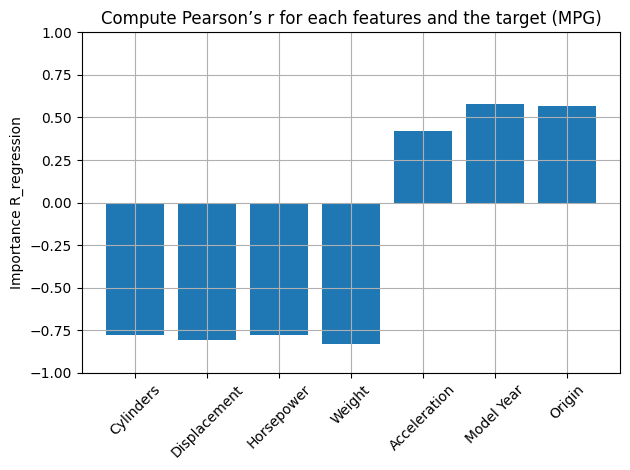

In [5]:
from sklearn.feature_selection import r_regression
# For further information on r_regression look at:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html#sklearn.feature_selection.r_regression

X= df_clean.iloc[:,1:].values
y = df_clean.iloc[:,0].values
importances = r_regression(X, y, center=True, force_finite=True)

fig, ax = plt.subplots()
ax.bar(range(7), importances, align = 'center')
ax.set_ylabel('Importance R_regression')
ax.set_xticks(range(7))
ax.set_xticklabels(df_clean.columns[1:], rotation = 45)
plt.title('Compute Pearson’s r for each features and the target (MPG)')
plt.ylim([-1,1])
plt.tight_layout()
plt.grid(True)
plt.show()

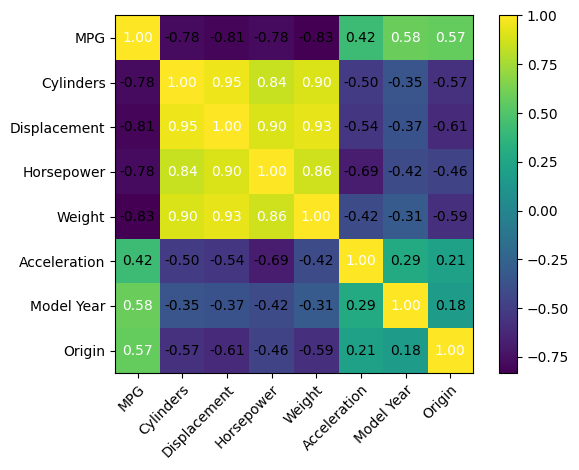

In [6]:
# The correlation matrix created with S.Raschka´s mlxtend library, provides the same results.
# Look at the first row where we compare the effect over MPG of the rest of the input variables.

from mlxtend.plotting import heatmap

cm = np.corrcoef(df_clean.values.T)
hm = heatmap(cm, row_names = df_clean.columns, column_names = df_clean.columns)
plt.tight_layout()
plt.show()

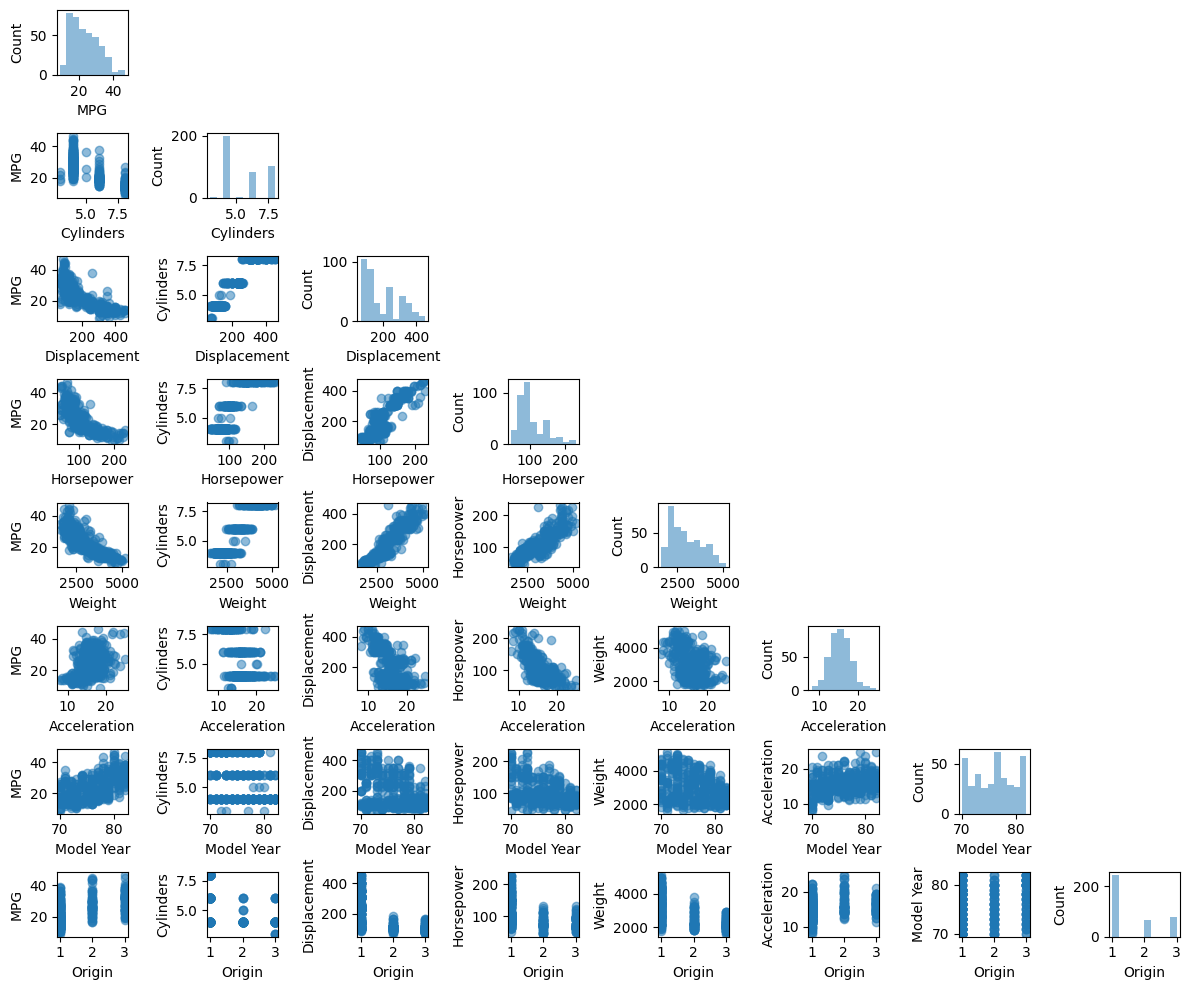

In [7]:
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(df_clean.values, figsize=(12, 10), 
                  names=df_clean.columns, alpha=0.5)
plt.tight_layout()
#plt.savefig('figures/09_04.png', dpi=300)
plt.show()

## Model Creation

We are going to create the model by using the Functional API, preprocessing the data in the model

thanks to the Keras Preprocessing Layers:
[Keras Preprocessing Layers](https://keras.io/api/layers/preprocessing_layers/)

Another way would be by using Scikit-Learn StandardScaler,  KBinsDiscretizer, but doing it in this way we keep 
all together in the same model ready for deployment.


### Preprocessing With Keras Preprocessing Layers

As numerical inputs we have:
- cylinders: multi-valued discrete
- displacement: continuous
- horsepower: continuous
- weight: continuous
- acceleration: continuous

These inputs need to be standarized

The following ones:
- model year: multi-valued discrete
- origin: multi-valued discrete

Need to be treated in a different way in the Pipeline, the "model year" can be discretized (bucketized) in different bins, whereas the "origin" can be encoded using "One-Hot Vectors" or "Embeddings".

Some reference links:

https://keras.io/guides/preprocessing_layers/
https://www.tensorflow.org/guide/keras/preprocessing_layers
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb
https://github.com/ageron/handson-ml3/blob/main/13_loading_and_preprocessing_data.ipynb
https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#full_example
https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
https://www.tensorflow.org/recommenders/examples/deep_recommenders

NOTE:

In the example below, the origin is "one_hot_encoded" through the pandas get_dummies function, instead of using the 
keras preprocessing layers as we do in this example.

https://www.tensorflow.org/tutorials/keras/regression#regression_using_a_dnn_and_multiple_inputs

In [8]:
# Model inputs 

df_train_full, df_test = train_test_split(df_clean, train_size = 0.8, random_state= 1)

# Extract features and targets and convert to arrays
X_full_train = df_train_full.iloc[:, 1:].values
y_full_train = df_train_full.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

df_train, df_valid = train_test_split(df_train_full, train_size = 0.2, random_state = 1)

X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

X_valid = df_valid.iloc[:, 1:].values
y_valid = df_valid.iloc[:, 0].values

#### Create a baseline model using the Functional API

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), name='discretization/Identity:0', description="created by layer 'discretization'")
[[   5.467742  191.58064   105.80645  2968.6128     15.490322]]


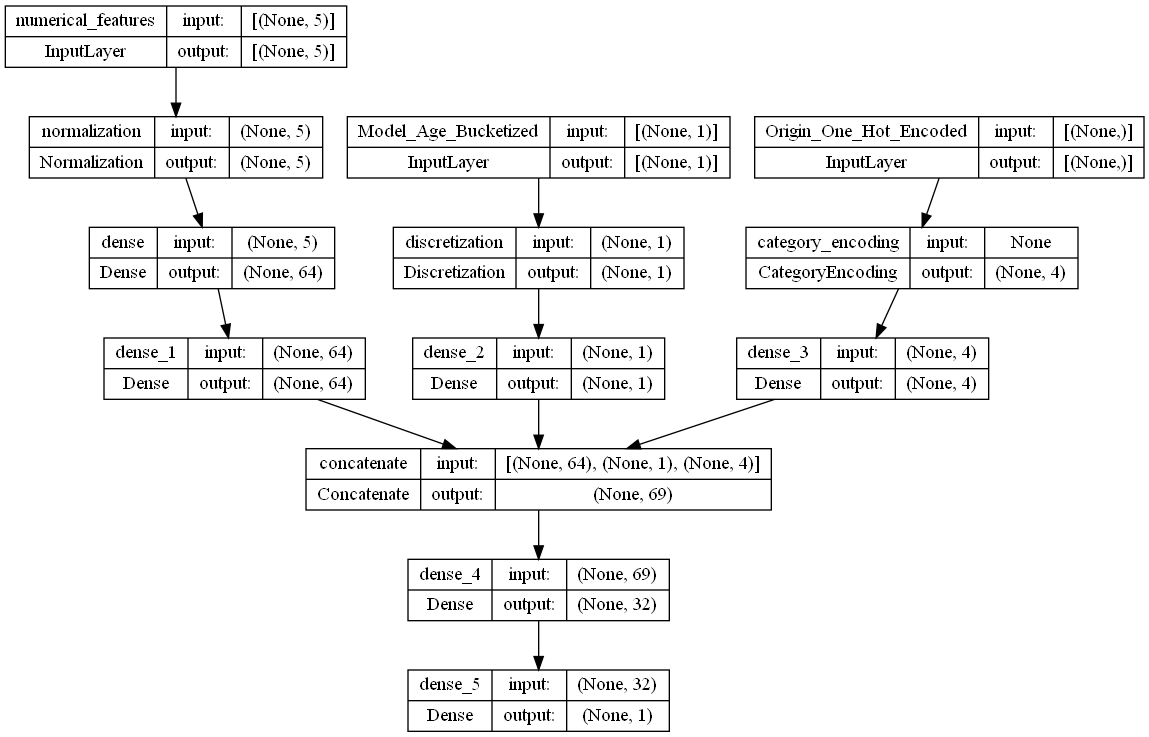

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Input Layers
input_num = keras.layers.Input(shape = (5,), name = 'numerical_features')
input_bucket = keras.layers.Input(shape = (1,), name = 'Model_Age_Bucketized')
input_cat = keras.layers.Input(shape = [], name = ' Origin_One_Hot_Encoded')

# It is needed to Standarize the numerical inputs, to discretize into buckets the 
# manufacturing year, and to embed or one-hot encode the numerical categorical features for
# the origin.
std_layer = keras.layers.Normalization(axis=-1)
bucket_layer = keras.layers.Discretization( 
    num_bins = 4,
    output_mode="int"
    )

cat_one_hot_layer = keras.layers.CategoryEncoding( 
    num_tokens = 4,
    output_mode="one_hot")

norm_num= std_layer(input_num)
bucket_year = bucket_layer(input_bucket)
one_hot_origin = cat_one_hot_layer(input_cat)


std_layer.adapt(X_train[:,0:5])
bucket_layer.adapt(X_train[:,5])

'''
Now it is important to mention how to operate with different inputs.

The Normalized numerical inputs pass through 2 Dense connected layers

The bucketized year and the categorized origin inputs, need after to pass through a Dense
layer without activation function. One-hot encoding followed by a Dense layer without activation
is equivalent to an Embedding layer

'''

hidden1 = tf.keras.layers.Dense(64, activation="relu")(norm_num)
hidden2 = tf.keras.layers.Dense(64, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(1)(bucket_year)
hidden4 = tf.keras.layers.Dense(4)(one_hot_origin)
concat_layer = tf.keras.layers.concatenate([hidden2, hidden3, hidden4])
hidden5 =  tf.keras.layers.Dense(32, activation="relu")(concat_layer)
output = tf.keras.layers.Dense(1)(hidden5)

# So our model using the Functional API will be:
model_fapi = tf.keras.Model(inputs=[input_num, input_bucket, input_cat], outputs=[output],name = 'Model_w_Preprocessing_Layers')

'''
The mean and variance values for the layer must be either supplied on construction or learned via adapt().
adapt() will compute the mean and variance of the data and store them as 
the layer's weights. adapt() should be called before fit(), evaluate(), or predict().

https://keras.io/guides/preprocessing_layers/#the-adapt-method
'''

# Preprocessed Tensors
print(norm_num)
print(bucket_year)

print(std_layer.mean.numpy())

# Select Optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_fapi.compile(loss="mae", optimizer=optimizer, metrics=["RootMeanSquaredError"])

from tensorflow.keras.utils import plot_model
plot_model(model_fapi, 'MPG_Regressor_Multi_Input.png', show_shapes = True)


In [10]:
# Train the model with the normalized and bucketized features
history = model_fapi.fit((X_train[:,0:5],X_train[:,5], X_train[:,6]), y_train, epochs=200,
validation_data=((X_valid[:,0:5], X_valid[:,5], X_valid[:,6]),y_valid),verbose = 0)

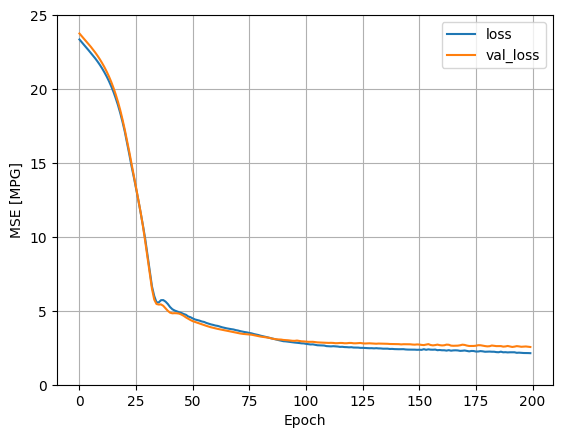

In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 25])
  plt.xlabel('Epoch')
  plt.ylabel('MSE [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [12]:
model_fapi.summary()

Model: "Model_w_Preprocessing_Layers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numerical_features (InputLayer  [(None, 5)]         0           []                               
 )                                                                                                
                                                                                                  
 normalization (Normalization)  (None, 5)            11          ['numerical_features[0][0]']     
                                                                                                  
 Model_Age_Bucketized (InputLay  [(None, 1)]         0           []                               
 er)                                                                                              
                                                                       

## Model Evaluation

In [13]:
# Evaluate and do some predictions
mse_test = model_fapi.evaluate((X_valid[:,0:5],X_valid[:,5],X_valid[:,6]), y_valid)
y_pred = model_fapi.predict((X_test[:,0:5],X_test[:,5], X_test[:,6]))

3/3 [==============================] - 1s 5ms/step


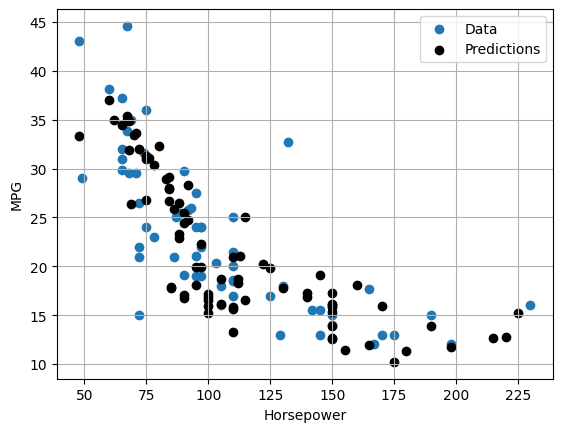

In [14]:
def plot_horsepower(x, y):
  plt.scatter(X_train[:,2], y_train, label='Data')
  plt.scatter(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.grid(True)
  plt.legend()

plot_horsepower(X_test[:,2],y_pred)

In [15]:
def build_and_compile_model():
  # Method to encapsulate model construction via Functional Api
  # Input Layers
  input_num = keras.layers.Input(shape = (5,), name = 'numerical_features')
  input_bucket = keras.layers.Input(shape = (1,), name = 'Model_Age_Bucketized')
  input_cat = keras.layers.Input(shape = [], name = ' Origin_One_Hot_Encoded')

  # It is needed to Standarize the numerical inputs, to discretize into buckets the 
  # manufacturing year, and to embed or one-hot encode the numerical categorical features for
  # the origin.
  std_layer = keras.layers.Normalization(axis=-1)
  bucket_layer = keras.layers.Discretization( 
      num_bins = 4,
      output_mode="int"
      )

  cat_one_hot_layer = keras.layers.CategoryEncoding( 
      num_tokens = 4,
      output_mode="one_hot")

  norm_num= std_layer(input_num)
  bucket_year = bucket_layer(input_bucket)
  one_hot_origin = cat_one_hot_layer(input_cat)


  std_layer.adapt(X_train[:,0:5])
  bucket_layer.adapt(X_train[:,5])
  '''
  Now it is important to mention how to operate with different inputs.

  The Normalized numerical inputs pass through 2 Dense connected layers

  The bucketized year and the categorized origin inputs, need after to pass through a Dense
  layer without activation function. One-hot encoding followed by a Dense layer without activation
  is equivalent to an Embedding layer
  '''
  # We will create a model with 2 hidden Dense Layers and one output layer with one neuron

  hidden1 = tf.keras.layers.Dense(64, activation="relu")(norm_num)
  hidden2 = tf.keras.layers.Dense(64, activation="relu")(hidden1)
  hidden3 = tf.keras.layers.Dense(1)(bucket_year)
  hidden4 = tf.keras.layers.Dense(4)(one_hot_origin)
  concat_layer = tf.keras.layers.concatenate([hidden2, hidden3, hidden4])
  hidden5 =  tf.keras.layers.Dense(32, activation="relu")(concat_layer)
  output = tf.keras.layers.Dense(1)(hidden5)

  # So our model using the Functional API will be:
  model = tf.keras.Model(inputs=[input_num, input_bucket, input_cat], outputs=[output],name = 'Model_w_Preprocessing_Layers')

  '''
  The mean and variance values for the layer must be either supplied on construction or learned via adapt().
  adapt() will compute the mean and variance of the data and store them as 
  the layer's weights. adapt() should be called before fit(), evaluate(), or predict().

  https://keras.io/guides/preprocessing_layers/#the-adapt-method
  '''

  # Select Optimizer and compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss="mae", optimizer=optimizer, metrics=["RootMeanSquaredError"])

  from tensorflow.keras.utils import plot_model
  plot_model(model, 'MPG_Regressor_Multi_Input.png', show_shapes = True)
  
  return model_fapi

#### Using Callbacks after model creation

In [16]:
cb_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_root_mean_squared_error',
        patience = 10
    ),
    # Basic Model (Saved with Callbacks)
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor = 'val_loss',
    save_best_only = True),
]

new_model = build_and_compile_model()
history_new_model = new_model.fit((X_train[:,0:5],X_train[:,5], X_train[:,6]), y_train, epochs=200,
validation_data=((X_valid[:,0:5], X_valid[:,5], X_valid[:,6]),y_valid),verbose = 1, callbacks = cb_list)

Epoch 1/200
2/2 [==============================] - 0s 318ms/step - loss: 2.1316 - root_mean_squared_error: 3.0724 - val_loss: 2.5600 - val_root_mean_squared_error: 3.3682
Epoch 2/200
2/2 [==============================] - 0s 120ms/step - loss: 2.1199 - root_mean_squared_error: 3.0692 - val_loss: 2.5985 - val_root_mean_squared_error: 3.4050
Epoch 3/200
2/2 [==============================] - 0s 125ms/step - loss: 2.1528 - root_mean_squared_error: 3.0849 - val_loss: 2.5789 - val_root_mean_squared_error: 3.3920
Epoch 4/200
2/2 [==============================] - 0s 232ms/step - loss: 2.1226 - root_mean_squared_error: 3.0610 - val_loss: 2.5409 - val_root_mean_squared_error: 3.3595
Epoch 5/200
2/2 [==============================] - 0s 116ms/step - loss: 2.1349 - root_mean_squared_error: 3.0598 - val_loss: 2.5559 - val_root_mean_squared_error: 3.3846
Epoch 6/200
2/2 [==============================] - 0s 106ms/step - loss: 2.1317 - root_mean_squared_error: 3.0637 - val_loss: 2.5636 - val_root_m

## Model Optimization with Keras Tuner

## Run Optimized Model

In [ ]:
##

## Save Optimized Model

In [ ]:
# Optimized Model